In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

# 中文字体设置 Chinese Font Setting
from matplotlib.font_manager import FontProperties
font_ch = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)
font_en = FontProperties(fname=r"c:\windows\fonts\times.ttf", size=12)



In [2]:
import numpy as np

class Experiment:
    """加载 .npz 文件为类属性，不改变原始格式"""

    def __init__(self, path, method_label):
        self.method_label = method_label
        data = np.load(path, allow_pickle=True)

        # 普通变量直接赋值
        self.input_term   = data['input_term']
        self.output_term  = data['output_term']
        self.all_pred_y1  = data['all_pred_y1']
        self.all_pred_y2  = data['all_pred_y2']
        self.all_pred_u1  = data['all_pred_u1']
        self.all_pred_u2  = data['all_pred_u2']
        self.all_pred_u3  = data['all_pred_u3']
        self.all_pred_u4  = data['all_pred_u4']
        self.set_y1       = data['set_y1']
        self.set_y2       = data['set_y2']

        # 特殊对象（如 scaler）用 .item()
        self.scalers = data['scalers'].item()

        print(f"✅ {self.method_label} 加载完成")



In [3]:
# ===== 四组实验数据 =====
exp_MLP        = Experiment('神经网络_4_2_残差网络_3层隐含层_更新_不改进_不更新.npz'    , 'MLP')
exp_MLP_AUM    = Experiment('神经网络_4_2_残差网络_3层隐含层_更新_不改进_更新.npz'      , 'MLP-AUM')
exp_SC_MLP     = Experiment('神经网络_4_2_残差网络_3层隐含层_更新_改进_不更新.npz'      , 'SC-MLP')
exp_SC_MLP_AUM = Experiment('神经网络_4_2_残差网络_3层隐含层_更新.npz'                  , 'SC-MLP-AUM')

✅ MLP 加载完成
✅ MLP-AUM 加载完成
✅ SC-MLP 加载完成
✅ SC-MLP-AUM 加载完成


In [4]:
def inverse_transform_and_evaluate(exp, startt=0, endd=None):
    """
    对传入的实验对象 exp 执行反归一化与误差计算，
    并将结果（y1_pred_inverse 等）存回 exp 内部。
    """
    
    # ✅ 现在 exp_MLP 内部多了这些属性：
    # exp_MLP.y1_pred_inverse
    # exp_MLP.y2_pred_inverse
    # exp_MLP.u1_pred_inverse
    # exp_MLP.u_limits
    # exp_MLP.rmse_y1 / exp_MLP.rmse_y2



    if endd is None:
        endd = len(exp.set_y1)

    # ====== 数据反归一化 ======
    exp.y1_pred_inverse = exp.scalers[exp.output_term[0]].inverse_transform(
        np.array(exp.all_pred_y1[startt:endd]).reshape(-1, 1)
    ).flatten()

    exp.y2_pred_inverse = exp.scalers[exp.output_term[1]].inverse_transform(
        np.array(exp.all_pred_y2[startt:endd]).reshape(-1, 1)
    ).flatten()

    exp.u1_pred_inverse = exp.scalers[exp.input_term[0]].inverse_transform(
        np.array(exp.all_pred_u1[startt:endd]).reshape(-1, 1)
    ).flatten()
    exp.u2_pred_inverse = exp.scalers[exp.input_term[1]].inverse_transform(
        np.array(exp.all_pred_u2[startt:endd]).reshape(-1, 1)
    ).flatten()
    exp.u3_pred_inverse = exp.scalers[exp.input_term[2]].inverse_transform(
        np.array(exp.all_pred_u3[startt:endd]).reshape(-1, 1)
    ).flatten()
    exp.u4_pred_inverse = exp.scalers[exp.input_term[3]].inverse_transform(
        np.array(exp.all_pred_u4[startt:endd]).reshape(-1, 1)
    ).flatten()

    # ====== 控制量上下限 ======
    exp.u_limits = {
        'u1': exp.scalers[exp.input_term[0]].inverse_transform(np.array([1, -1]).reshape(-1, 1)).flatten(),
        'u2': exp.scalers[exp.input_term[1]].inverse_transform(np.array([1, -1]).reshape(-1, 1)).flatten(),
        'u3': exp.scalers[exp.input_term[2]].inverse_transform(np.array([1, -1]).reshape(-1, 1)).flatten(),
        'u4': exp.scalers[exp.input_term[3]].inverse_transform(np.array([1, -1]).reshape(-1, 1)).flatten(),
    }
    
    print(f"{exp.method_label:10s} 控制量上下限：")
    for k, v in exp.u_limits.items():
        print(f"  {k}: [{v[0]:10.4f}, {v[1]:10.4f}]")


    # ====== 计算平均误差 ======
    exp.rmse_y1 = np.mean(np.fabs(exp.set_y1[startt:endd] - exp.y1_pred_inverse))
    exp.rmse_y2 = np.mean(np.fabs(exp.set_y2[startt:endd] - exp.y2_pred_inverse))

    print(f"{exp.method_label:10s} 平均误差 y1：{exp.rmse_y1:.4f}")
    print(f"{exp.method_label:10s} 平均误差 y2：{exp.rmse_y2:.4f}")
    print(f"\n")

    # ====== 返回结果字典 ======
    return {
        'y1_pred_inverse': exp.y1_pred_inverse,
        'y2_pred_inverse': exp.y2_pred_inverse,
        'u1_pred_inverse': exp.u1_pred_inverse,
        'u2_pred_inverse': exp.u2_pred_inverse,
        'u3_pred_inverse': exp.u3_pred_inverse,
        'u4_pred_inverse': exp.u4_pred_inverse,
        'u_limits': exp.u_limits,
        'rmse_y1': exp.rmse_y1,
        'rmse_y2': exp.rmse_y2
    }


In [5]:
# 调用函数
startt = 50
endd = 150

# list(vars(exp_MLP).keys())

result = inverse_transform_and_evaluate(exp_MLP         , startt=startt, endd=endd)
result = inverse_transform_and_evaluate(exp_MLP_AUM     , startt=startt, endd=endd)
result = inverse_transform_and_evaluate(exp_SC_MLP      , startt=startt, endd=endd)
result = inverse_transform_and_evaluate(exp_SC_MLP_AUM  , startt=startt, endd=endd)



MLP        控制量上下限：
  u1: [20073.6825,     0.0003]
  u2: [   33.7255,     0.0000]
  u3: [    0.4321,    -0.0003]
  u4: [ 1220.0298,   575.4650]
MLP        平均误差 y1：10.4424
MLP        平均误差 y2：0.0658


MLP-AUM    控制量上下限：
  u1: [20073.6825,     0.0003]
  u2: [   33.7255,     0.0000]
  u3: [    0.4321,    -0.0003]
  u4: [ 1220.0298,   575.4650]
MLP-AUM    平均误差 y1：3.4522
MLP-AUM    平均误差 y2：0.0211


SC-MLP     控制量上下限：
  u1: [20073.6825,     0.0003]
  u2: [   33.7255,     0.0000]
  u3: [    0.4321,    -0.0003]
  u4: [ 1220.0298,   575.4650]
SC-MLP     平均误差 y1：2.0149
SC-MLP     平均误差 y2：0.0184


SC-MLP-AUM 控制量上下限：
  u1: [20073.6825,     0.0003]
  u2: [   33.7255,     0.0000]
  u3: [    0.4321,    -0.0003]
  u4: [ 1220.0298,   575.4650]
SC-MLP-AUM 平均误差 y1：0.6255
SC-MLP-AUM 平均误差 y2：0.0046




In [6]:
list(vars(exp_MLP).keys())

['method_label',
 'input_term',
 'output_term',
 'all_pred_y1',
 'all_pred_y2',
 'all_pred_u1',
 'all_pred_u2',
 'all_pred_u3',
 'all_pred_u4',
 'set_y1',
 'set_y2',
 'scalers',
 'y1_pred_inverse',
 'y2_pred_inverse',
 'u1_pred_inverse',
 'u2_pred_inverse',
 'u3_pred_inverse',
 'u4_pred_inverse',
 'u_limits',
 'rmse_y1',
 'rmse_y2']

In [7]:

time_term= '时间戳h'
input_term222 = ['Oxygen Flow/(m\u00b3/h)', 'Cold Air Flow/(m\u00b3/h)', 'Hot Air Pressure/kPa', 'Hot Air Temperature/℃']
output_term222 = ['MIT/℃', '[Si]/%']
input_term333 =  ['Oxygen Flow', 'Cold Air Flow', 'Hot Air Pressure', 'Hot Air Temperature']
output_term333 = ['MIT', '[Si]']

# 用于子图编号的字母序列
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

dtiem1 = 0
dtiem2 = 1.10

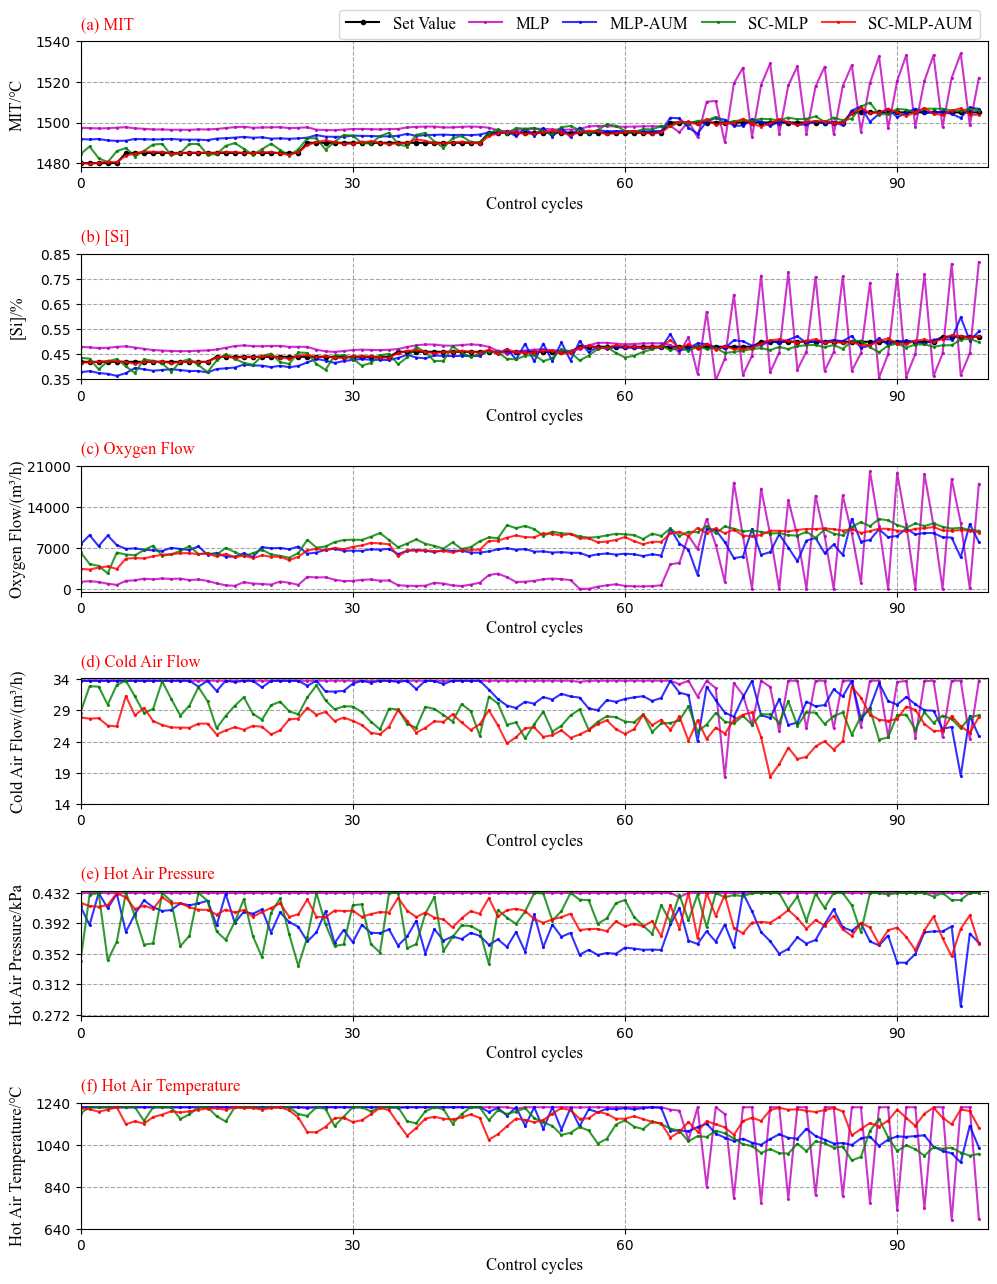

In [10]:
plt.figure(figsize=(10, 13))


# 第一个维度的曲线
# -----------------------------------------------------------------
ax = plt.subplot(6, 1, 1)

# ---- 绘制设定值 ----
plt.plot(exp_MLP.set_y1[startt:endd],    label='Set Value',                 color='k', linewidth=1.5, alpha=1.0, linestyle='-', marker='o', markersize=3.0)

# ---- 绘制四种模型预测曲线 ----
plt.plot(exp_MLP.y1_pred_inverse,        label=exp_MLP.method_label,        color='m', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_MLP_AUM.y1_pred_inverse,    label=exp_MLP_AUM.method_label,    color='b', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_SC_MLP.y1_pred_inverse,     label=exp_SC_MLP.method_label,     color='g', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_SC_MLP_AUM.y1_pred_inverse, label=exp_SC_MLP_AUM.method_label, color='r', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)



# ---- 辅助线与网格 ----
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.grid(linestyle='--', alpha=0.7, color='gray')

# ---- 坐标范围与刻度 ----
plt.xlim(0, endd - startt)
plt.xticks(range(0, endd - startt + 1, 30))
plt.ylim([1478, 1540])
plt.yticks(range(1480, 1541, 20))


# ---- 坐标标签与标题 ----
plt.ylabel('MIT/℃', fontproperties=font_en)           # 纵坐标标签（英文）


ax.set_xlabel('Control cycles', fontproperties=font_en) # 横坐标标签
ax.yaxis.set_label_coords(-0.06, 0.5)                   # 纵轴标题靠左对齐

# ---- 子图标题 ----
ax.text(    dtiem1, dtiem2,     f'{subplot_labels[0]} {output_term333[0]}',    transform=ax.transAxes,    ha='left',     fontproperties=font_en, color='red')

# -----------------------------------------------------------------





# ---- 图例 ----
# 设置更小的字号，比如8号

font_legend = deepcopy(font_en)
font_legend.set_size(12)


plt.legend(
    prop=font_legend,   # 使用较小字体
    ncol=5,             # ← 设置两列排列
    loc='upper right',   # ✅ 正确写法：右上角,
    bbox_to_anchor=(1.0, 1.32),  # x 稍小，y 稍低 → 向左下偏移
    # loc='best',         # 自动选择最合适的位置
    columnspacing=0.8,  # 两列之间的间距（可调）
    labelspacing=0.4    # 行间距（可调）
)




# 第二个维度的曲线
# -----------------------------------------------------------------
ax = plt.subplot(6, 1, 2)

# ---- 绘制设定值 ----
plt.plot(exp_MLP.set_y2[startt:endd],    label='Set Value',                 color='k', linewidth=1.5, alpha=1.0, linestyle='-', marker='o', markersize=3.0)

# ---- 绘制四种模型预测曲线 ----
plt.plot(exp_MLP.y2_pred_inverse,        label=exp_MLP.method_label,        color='m', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_MLP_AUM.y2_pred_inverse,    label=exp_MLP_AUM.method_label,    color='b', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_SC_MLP.y2_pred_inverse,     label=exp_SC_MLP.method_label,     color='g', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_SC_MLP_AUM.y2_pred_inverse, label=exp_SC_MLP_AUM.method_label, color='r', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)



# ---- 辅助线与网格 ----
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.grid(linestyle='--', alpha=0.7, color='gray')

# ---- 坐标范围与刻度 ----
plt.xlim(0, endd - startt)
plt.xticks(range(0, endd - startt + 1, 30))
plt.ylim([0.35, 0.85])
plt.yticks(np.arange(0.35, 0.86, 0.1))


# ---- 坐标标签与标题 ----
plt.ylabel('[Si]/%', fontproperties=font_en)           # 纵坐标标签（英文）


ax.set_xlabel('Control cycles', fontproperties=font_en) # 横坐标标签
ax.yaxis.set_label_coords(-0.06, 0.5)                   # 纵轴标题靠左对齐

# ---- 子图标题 ----
ax.text(    dtiem1, dtiem2,     f'{subplot_labels[1]} {output_term333[1]}',    transform=ax.transAxes,    ha='left',     fontproperties=font_en, color='red')

# -----------------------------------------------------------------






# u1曲线
# -----------------------------------------------------------------
ax = plt.subplot(6, 1, 3)


# ---- 绘制四种模型预测曲线 ----
plt.plot(exp_MLP.u1_pred_inverse,        label=exp_MLP.method_label,        color='m', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_MLP_AUM.u1_pred_inverse,    label=exp_MLP_AUM.method_label,    color='b', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_SC_MLP.u1_pred_inverse,     label=exp_SC_MLP.method_label,     color='g', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_SC_MLP_AUM.u1_pred_inverse, label=exp_SC_MLP_AUM.method_label, color='r', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)



# ---- 辅助线与网格 ----
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.grid(linestyle='--', alpha=0.7, color='gray')

# ---- 坐标范围与刻度 ----
plt.xlim(0, endd - startt)
plt.xticks(range(0, endd - startt + 1, 30))
plt.ylim([-500, 21000])
plt.yticks(np.arange(0, 21001, 7000))


# ---- 坐标标签与标题 ----
plt.ylabel(input_term222[0], fontproperties=font_en)           # 纵坐标标签（英文）


ax.set_xlabel('Control cycles', fontproperties=font_en) # 横坐标标签
ax.yaxis.set_label_coords(-0.06, 0.5)                   # 纵轴标题靠左对齐

# ---- 子图标题 ----
ax.text(    dtiem1, dtiem2,     f'{subplot_labels[2]} {input_term333[0]}',    transform=ax.transAxes,    ha='left',     fontproperties=font_en, color='red')


# -----------------------------------------------------------------





# u2曲线
# -----------------------------------------------------------------
ax = plt.subplot(6, 1, 4)


# ---- 绘制四种模型预测曲线 ----
plt.plot(exp_MLP.u2_pred_inverse,        label=exp_MLP.method_label,        color='m', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_MLP_AUM.u2_pred_inverse,    label=exp_MLP_AUM.method_label,    color='b', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_SC_MLP.u2_pred_inverse,     label=exp_SC_MLP.method_label,     color='g', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_SC_MLP_AUM.u2_pred_inverse, label=exp_SC_MLP_AUM.method_label, color='r', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)



# ---- 辅助线与网格 ----
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.grid(linestyle='--', alpha=0.7, color='gray')

# ---- 坐标范围与刻度 ----
plt.xlim(0, endd - startt)
plt.xticks(range(0, endd - startt + 1, 30))
plt.ylim([14, 34.1])
plt.yticks(np.arange(14, 35, 5))


# ---- 坐标标签与标题 ----
plt.ylabel(input_term222[1], fontproperties=font_en)           # 纵坐标标签（英文）


ax.set_xlabel('Control cycles', fontproperties=font_en) # 横坐标标签
ax.yaxis.set_label_coords(-0.06, 0.5)                   # 纵轴标题靠左对齐

# ---- 子图标题 ----
ax.text(    dtiem1, dtiem2,     f'{subplot_labels[3]} {input_term333[1]}',    transform=ax.transAxes,    ha='left',     fontproperties=font_en, color='red')



# -----------------------------------------------------------------








# u3曲线
# -----------------------------------------------------------------
ax = plt.subplot(6, 1, 5)


# ---- 绘制四种模型预测曲线 ----
plt.plot(exp_MLP.u3_pred_inverse,        label=exp_MLP.method_label,        color='m', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_MLP_AUM.u3_pred_inverse,    label=exp_MLP_AUM.method_label,    color='b', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_SC_MLP.u3_pred_inverse,     label=exp_SC_MLP.method_label,     color='g', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_SC_MLP_AUM.u3_pred_inverse, label=exp_SC_MLP_AUM.method_label, color='r', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)



# ---- 辅助线与网格 ----
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.grid(linestyle='--', alpha=0.7, color='gray')

# ---- 坐标范围与刻度 ----
plt.xlim(0, endd - startt)
plt.xticks(range(0, endd - startt + 1, 30))
plt.ylim([0.270, 0.435])
plt.yticks(np.arange(0.272, 0.4321, 0.040))


# ---- 坐标标签与标题 ----
plt.ylabel(input_term222[2], fontproperties=font_en)           # 纵坐标标签（英文）


ax.set_xlabel('Control cycles', fontproperties=font_en) # 横坐标标签
ax.yaxis.set_label_coords(-0.06, 0.5)                   # 纵轴标题靠左对齐

# ---- 子图标题 ----
ax.text(    dtiem1, dtiem2,     f'{subplot_labels[4]} {input_term333[2]}',    transform=ax.transAxes,    ha='left',     fontproperties=font_en, color='red')



# -----------------------------------------------------------------










# u4曲线
# -----------------------------------------------------------------
ax = plt.subplot(6, 1, 6)


# ---- 绘制四种模型预测曲线 ----
plt.plot(exp_MLP.u4_pred_inverse,        label=exp_MLP.method_label,        color='m', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_MLP_AUM.u4_pred_inverse,    label=exp_MLP_AUM.method_label,    color='b', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_SC_MLP.u4_pred_inverse,     label=exp_SC_MLP.method_label,     color='g', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)
plt.plot(exp_SC_MLP_AUM.u4_pred_inverse, label=exp_SC_MLP_AUM.method_label, color='r', linewidth=1.5, alpha=0.8, linestyle='-', marker='o', markersize=1.3)



# ---- 辅助线与网格 ----
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.grid(linestyle='--', alpha=0.7, color='gray')

# ---- 坐标范围与刻度 ----
plt.xlim(0, endd - startt)
plt.xticks(range(0, endd - startt + 1, 30))
plt.ylim([640, 1240])
plt.yticks(np.arange(640, 1241, 200))


# ---- 坐标标签与标题 ----
plt.ylabel(input_term222[3], fontproperties=font_en)           # 纵坐标标签（英文）


ax.set_xlabel('Control cycles', fontproperties=font_en) # 横坐标标签
ax.yaxis.set_label_coords(-0.06, 0.5)                   # 纵轴标题靠左对齐

# ---- 子图标题 ----
ax.text(    dtiem1, dtiem2,     f'{subplot_labels[5]} {input_term333[3]}',    transform=ax.transAxes,    ha='left',     fontproperties=font_en, color='red')



# -----------------------------------------------------------------






# 调整子图布局
plt.tight_layout()


plt.savefig(
    '1四组实验数据.png',   # 保存文件名
    dpi=1200,                # 分辨率（默认100，600已经是印刷级）
    bbox_inches='tight',    # 自动裁剪空白边
    pad_inches=0.05,         # 四周留少量空白
    transparent=False       # 是否透明背景
)



plt.show()